In [28]:
# Libraries
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
from collections import defaultdict
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Ventricule",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
}
TISSUES = sorted([item for item in list(SHORTEN.keys())])# if "Brain" not in item]

regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/'#LR_SummaryTest_Table.tsv'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'


In [30]:
"""
Fisher test at each tissue
        Causal_e  Not_e-causal
Motif M   eM    M-eM
Non M mo  e-eM   --  
"""

#open files
#Motif by strands
#S = pd.read_csv(strand, sep='\t', header=None)
#S.columns =['chrom','str.start','end','motiflength', 'For_motif','Rev_motif']
#G = pd.merge(R, S[['chrom','str.start','For_motif','Rev_motif']], on=['chrom','str.start'], how='inner')
#A = pd.read_csv('/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv', sep=',')
#A['gene']=A['gene.id'];                 A['chrom'] = A['gene.chr']
#GG = pd.merge(G, A[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
#GG['Motif']=GG['For_motif'].where(GG['gene.strand'] == '+', GG['Rev_motif']) #Strand annotation
#del GG['motif']
#GG['motif'] = GG['Motif']
#######End Optional
#print('Strand-based motifs')
#R = GG      #

O=defaultdict(list)
Mapdata = {}
Mset=[]
for tis in TISSUES:
    #field ='eSTR.'+SHORTEN[tis]
    R = pd.read_csv(regr+tis+'/Master.table', sep='\t')
    R = R.loc[R['qvalue']<=0.1]
    # Focus on causal estrs and motifs
    causal = [x for x in list(R['top.variant']) if 'STR_' in x]
    data = R[["gene","chrom", "str.start","motif",'top.variant']]#,"best.score","best.tissue","INTRON"]]
    data_e = data.loc[data['top.variant'].isin(causal)]

    # eSTR motifs
    Motifs = list(set(list(data_e['motif'])))
    
    #Numbers
    Estr = data_e.shape[0]
    Str = data.shape[0]
#    print(tis,'\t',Estr,' causal data ', Str, ' all eSTRs ',len(Motifs),' motifs\n', '--'.join(sorted(Motifs)),'\n ...' )
    sig_motifs=[]
    All = []
    for M in Motifs:
        #motifs
        data_eM = data_e.loc[data_e['motif']==M]
        data_M = data.loc[data['motif']==M]
        #Numbers
        Mestrs = data_eM.shape[0]
        Mstrs = data_M.shape[0]
        #Cont. Table
        CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
        #Fisher
        oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])
        All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
        O[M].append(oddsratio)
        if pv<=0.1:
            sig_motifs.append([M,-np.log10(pv)])
    Mapdata[tis] = All  
    Mset=[s for s in Motifs if s not in Mset] + Mset
print(len(Mset))
#Tissues that appears in all tissues


#Gather pvalues
pdata = np.zeros((len(TISSUES), len(Mset)))
d=[]
for i in range(len(TISSUES)):
    T = TISSUES[i]
    for j in range(len(Mset)):
        m=Mset[j]
        val = [s[2] for s in  Mapdata[T] if s[0]==m ]
        if val==[]:
            pdata[i][j] =0
        else:
            pdata[i][j] =val[0]
    if sum(pdata[i])<=0:
        d.append(i)
#prettify it#
df = pd.DataFrame(pdata)
df.columns = Mset
df.index = [SHORTEN[x] for x in TISSUES]
df['tissue'] = [SHORTEN[x] for x in TISSUES]
df.sort_values('tissue')
del df['tissue']
pdata = df[sorted(list(df.columns))]

66


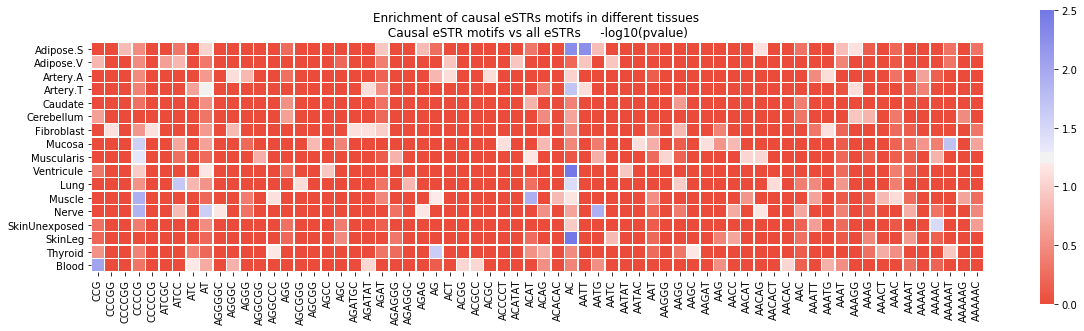

In [32]:
#plot all
fig, ax = plt.subplots(figsize=(20,18))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdata, cmap=cmap, annot_kws={"size": 8},
            vmin=0, vmax=2.5 , square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.3},
           yticklabels=[x for x in pdata.index], 
           xticklabels=[x for x in pdata.columns]);
ax.invert_xaxis();
plt.title('Enrichment of causal eSTRs motifs in different tissues \n Causal eSTR motifs vs all eSTRs     -log10(pvalue) ')
plt.show()


In [33]:
"""
Fisher test at each tissue
        estrs  Not_estrs
Motif M   eM    M-eM
Non M mo  e-eM   --  
"""
#open files
O=defaultdict(list)
Mapdata = {}
Mset=[]
    
for tis in TISSUES:
    #field ='eSTR.'+SHORTEN[tis]
    R = pd.read_csv(regr+tis+'/Master.table', sep='\t')
    # Focus on estrs and motifs
    data = R[["gene","chrom", "str.start","motif",'qvalue']]#,"best.score","best.tissue","INTRON"]]
    data_e = data.loc[data['qvalue']<=0.1]

    # eSTR motifs
    Motifs = list(set(list(data_e['motif'])))

    #Numbers
    Estr = data_e.shape[0]
    Str = data.shape[0] 
    sig_motifs=[]
    All = []
    for M in Motifs:
        #motifs
        data_eM = data_e.loc[data_e['motif']==M]
        data_M = data.loc[data['motif']==M]
        #Numbers
        Mestrs = data_eM.shape[0]
        Mstrs = data_M.shape[0]
        #Cont. Table
        CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
        #Fisher
        oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])
        All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
        O[M].append(oddsratio)
        if pv<=0.05:
            sig_motifs.append([M,-np.log10(pv)])
    Mapdata[tis] = All  
    Mset=[s for s in Motifs if s not in Mset] + Mset
#
M=[]    
print(len(Mset))
for s in Mset:
    if len(O[s])>=len(TISSUES)-2:
        M.append(s)
#
print(len(M))

#Gather pvalues
pdata = np.zeros((len(TISSUES), len(Mset)))
for i in range(len(TISSUES)):
    T = TISSUES[i]
    for j in range(len(Mset)):
        m=Mset[j]
        val = [s[2] for s in  Mapdata[T] if s[0]==m ]
        if val==[]:
            pdata[i][j] =0
        else:
            pdata[i][j] =val[0]
            
#prettify it#
df = pd.DataFrame(pdata)
df.columns = Mset
df.index = [SHORTEN[x] for x in TISSUES]
df['tissue'] = [SHORTEN[x] for x in TISSUES]
df.sort_values('tissue')
del df['tissue']

117
28


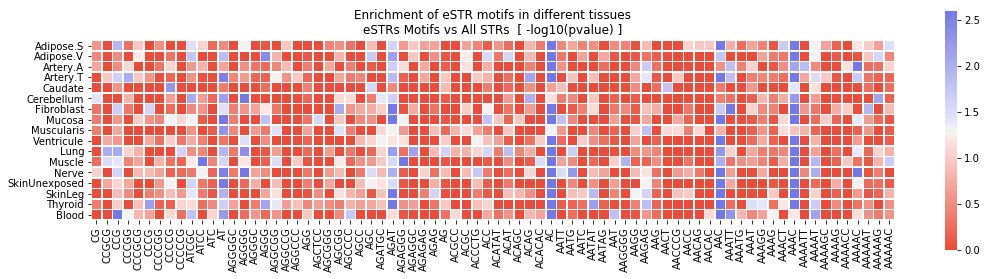

In [38]:
#plot all
for m in df.columns:
    if sum(df[m])<=2:
        del df[m]
#
pdata = df[sorted(list(df.columns))]
fig, ax = plt.subplots(figsize=(18, 22))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdata, cmap=cmap, annot_kws={"size": 6},
            vmin=0, vmax=2.6, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.2},
           yticklabels=[x for x in pdata.index], 
           xticklabels=[x for x in pdata.columns]);
ax.invert_xaxis();
plt.title('Enrichment of eSTR motifs in different tissues\neSTRs Motifs vs All STRs  [ -log10(pvalue) ]')
plt.show()